# Notebook for HDBSCAN analysis

In [1]:
#importing libraries
import resources.hai as hai
import pandas as pd
import numpy as np
import utils as u
from copy import deepcopy
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components, minimum_spanning_tree
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import minkowski
import matplotlib.pyplot as plt
import sys
import hdbscan
from sklearn.metrics import adjusted_rand_score
import random
import multiprocessing
from heapq import heapify, heappop, heappush, heappushpop, merge
from itertools import groupby

In [15]:
#loading datasets
dsname = "Datasets/circles_seed_1227_size_1000.csv"
dataset = pd.read_csv(dsname, header=None).values
mpts = 20
mcls = mpts

In [16]:
pre_calc_nnd = u.NNDescent(dataset, mpts-1)
cluster_nndescent_frozen = u.HDBSCAN_Descent_frozen(dataset, mpts, mcls, pre_calc_nnd=pre_calc_nnd)
cluster_nndescent_naive = u.HDBSCAN_Descent_naive(dataset, mpts, mcls, pre_calc_nnd=pre_calc_nnd)
ocl = u.HDBSCAN(dataset, mpts, mcls)
# ocl = hdbscan.HDBSCAN(min_cluster_size=mcls,
#                 min_samples=mpts,
#                 match_reference_implementation=True,
#                 gen_min_span_tree=True,
#                 approx_min_span_tree=False,
#                 allow_single_cluster=True)

In [17]:
cluster_nndescent_frozen.run()
cluster_nndescent_naive.run()
ocl.run()
#ocl.fit(dataset)

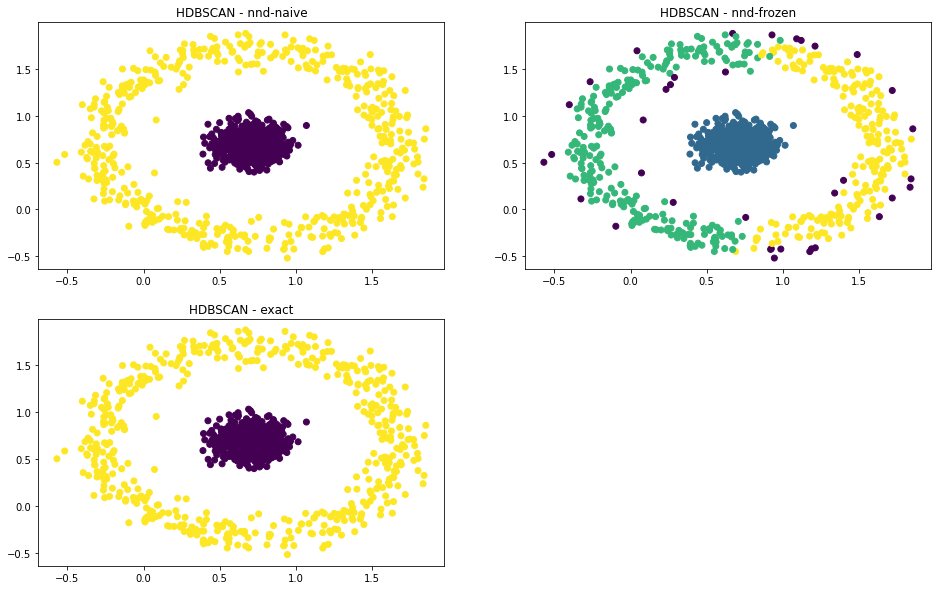

In [18]:
plt.figure(figsize=(16,10))
plt.subplot(2,2,1)
plt.title("HDBSCAN - nnd-naive")
plt.scatter([a[0] for a in dataset], [a[1] for a in dataset], c=cluster_nndescent_naive.labels)
plt.subplot(2,2,2)
plt.title("HDBSCAN - nnd-frozen")
plt.scatter([a[0] for a in dataset], [a[1] for a in dataset], c=cluster_nndescent_frozen.labels)
plt.subplot(2,2,3)
plt.title("HDBSCAN - exact")
plt.scatter([a[0] for a in dataset], [a[1] for a in dataset], c=ocl.labels)
plt.show()

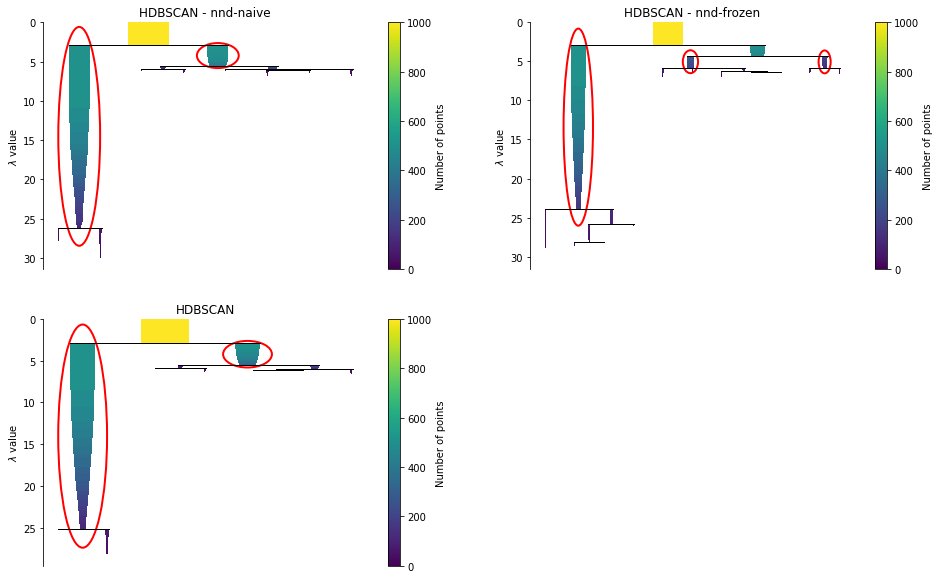

In [19]:
plt.figure(figsize=(16,10))
plt.subplot(2,2,1)
plt.title("HDBSCAN - nnd-naive")
hdbscan.hdbscan_.CondensedTree(cluster_nndescent_naive.condensed_tree).plot(select_clusters=True)
plt.subplot(2,2,2)
plt.title("HDBSCAN - nnd-frozen")
hdbscan.hdbscan_.CondensedTree(cluster_nndescent_frozen.condensed_tree).plot(select_clusters=True)
plt.subplot(2,2,3)
plt.title("HDBSCAN")
hdbscan.hdbscan_.CondensedTree(ocl.condensed_tree).plot(select_clusters=True)
#ocl.condensed_tree_.plot(select_clusters=True)
plt.show()

# Indexes Scores - HAI and AR 

In [20]:
#calculating  HAI
hierarchies = {
    "cluster_nndescent_frozen":np.rot90(cluster_nndescent_frozen.hierarchy),
    "cluster_nndescent_naive":np.rot90(cluster_nndescent_naive.hierarchy),
    "ocl": np.rot90(ocl.hierarchy),
}

ground_truth = hierarchies["ocl"]
for l1, h1 in hierarchies.items():
    print(l1, hai.compare(h1, ground_truth))

cluster_nndescent_frozen 0.9999197294290185
cluster_nndescent_naive 0.9999316250802973
ocl 1.0


In [21]:
#calculating Adjusted Rand
adjusted_rand_scores = [
    "Adjusted Rand scores:\n",
    f"AR nnd Naive:\t{adjusted_rand_score(ocl.labels, cluster_nndescent_naive.labels):.4f}",
    f"AR nnd Frozen:\t{adjusted_rand_score(ocl.labels, cluster_nndescent_frozen.labels):.4f}"
]
print('\n'.join(adjusted_rand_scores))

Adjusted Rand scores:

AR nnd Naive:	1.0000
AR nnd Frozen:	0.7204


# MST Analysis

In [22]:
#calculating number of extra edges needed to build the MST of the complete graph
n_edges_to_connect = [
    f"Number of Edges extra edges used to connect components:\n",
    f"nnd Naive:\t{cluster_nndescent_naive.n_connect_edges}",
    f"nnd Frozen:\t{cluster_nndescent_frozen.n_connect_edges}"
]
print("\n".join(n_edges_to_connect))

Number of Edges extra edges used to connect components:

nnd Naive:	0
nnd Frozen:	0


In [23]:
sorted_distance_matrix = u.get_sorted_dist_matrix(dataset)
# mst = set(u.get_edges(u.get_mst(u.to_adj_m(sorted_distance_matrix)).toarray()))

In [24]:
#Comparing aproximated MST error with exact MST over mutual reachability space 
knn_position_error = []
knn_mst_error = []
for mpts in range(2, 50):
    knn = u.get_knn(sorted_distance_matrix, k=mpts-1)
    alen = u.get_n_neighbors(knn)
    core_d = [row[mpts-2][0] for row in sorted_distance_matrix]
    dmreach = [sorted([(max(e[0], core_d[e[1]], core_d[i]), e[1]) for e in row]) for i, row in enumerate(sorted_distance_matrix)]
    dmreach_knn = [sorted([(max(e[0], core_d[e[1]], core_d[i]), e[1]) for e in row]) for i, row in enumerate(knn)]
    mst = u.get_mst(u.to_adj_m(dmreach)).toarray()
    knnmst = u.get_mst(u.to_adj_m(dmreach_knn)).toarray()
    e_priori = 0
    for i, row in enumerate(dmreach_knn):
        for j, elem in enumerate(row):
            if dmreach[i][j][1] != elem[1]:
                e_priori += 1
    print(f"mpts = {mpts:2d}, erro: {e_priori / sum(alen):.6f}, mst erro: {(mst.reshape((1,len(dataset)**2)).sum() - knnmst.reshape((1,len(dataset)**2)).sum())/mst.reshape((1,len(dataset)**2)).sum():.20f}")

mpts =  2, erro: 0.000000, mst erro: 0.38184876139713880283
mpts =  3, erro: 0.072000, mst erro: 0.04061504552181090244
mpts =  4, erro: 0.128667, mst erro: 0.00743822621745397067
mpts =  5, erro: 0.166000, mst erro: 0.00525272928416581440
mpts =  6, erro: 0.178000, mst erro: 0.00547447395194686996
mpts =  7, erro: 0.195167, mst erro: 0.00510808608838347541
mpts =  8, erro: 0.211429, mst erro: 0.00476500757373451902
mpts =  9, erro: 0.219375, mst erro: 0.00443332918181295766
mpts = 10, erro: 0.229778, mst erro: 0.00426099362518833624
mpts = 11, erro: 0.241300, mst erro: 0.00404742713958156260
mpts = 12, erro: 0.236182, mst erro: 0.00386618818014154535
mpts = 13, erro: 0.252250, mst erro: 0.00368757569189957606
mpts = 14, erro: 0.258615, mst erro: 0.00348594992594098005
mpts = 15, erro: 0.266786, mst erro: 0.00326596555518591375
mpts = 16, erro: 0.273533, mst erro: 0.00328322352694606062
mpts = 17, erro: 0.277438, mst erro: 0.00317099556026469035
mpts = 18, erro: 0.280118, mst erro: 0.0